# NFL Comp - 9th Place Solution
This is the gold medal 9th place final submission inference notebook for team `Deep Impact` ( @vaghefi @cdeotte @theoviel @jinssaa ) solution to Kaggle's NFL Comp. This notebook is explained here: https://www.kaggle.com/c/nfl-impact-detection/discussion/209012

First we find potential helmet impacts using a 2D detection model. Second, we classify each potential bbox with a 3D classification model. Lastly, we apply post process to remove false positives. This notebook achieves CV 0.5125, Public LB 0.4931, and 9th Place Private LB 0.5153!
  
Code to train the 3D classification models is posted here: https://github.com/TheoViel/nfl_impact_detection

# Hyperparameters

### Best CV [0.5125]

In [1]:
DEBUG = False

DET_THRESHOLD = 0.35 -0.02
CLS_THRESHOLD = 0.48

# Change threshold after frame
SWITCH_FRAME = 150
DET_THRESHOLD2 = 0.40 -0.02
CLS_THRESHOLD2 = 0.65

# Lower thresholds for sideline
DELTA_CLS = -0.07
DELTA_DET = -0.05

# Adjacency post-processing
NMS_THRESHOLD = 0.41
MAX_FRAME_DIST = 9
N_TIMES = 1

# View post-processing
MIN_DIST = 4
VIEW_THRESHOLD = 0.86  

# Boxes expansion
R = 0.22

# Ensemble
CLS_3D_NEW = 2 #these are i3d, slowonly, slowfast
CLS_3D_OLD = 1 # these are three resnet18, and one resnet34
CLS_2D = 0 #these are three 2d classification models

# Model
config_file = '../input/detectron-full/detectors_cascade_x101_fold_0_4_2_.py'
checkpoint_file = '../input/detectron-full/epoch_7.pth'

# Detection Model

## Initialization

### Packages

In [2]:
!pip install ../input/mmdetectionv260/addict-2.4.0-py3-none-any.whl
!pip install ../input/mmdetectionv260/mmcv_full-latesttorch1.6.0cu102-cp37-cp37m-manylinux1_x86_64.whl
!pip install ../input/mmdetectionv260/mmpycocotools-12.0.3-cp37-cp37m-linux_x86_64.whl
!pip install ../input/mmdetectionv260/mmdet-2.6.0-py3-none-any.whl

Processing /kaggle/input/mmdetectionv260/addict-2.4.0-py3-none-any.whl
Processing /kaggle/input/mmdetectionv260/mmcv_full-latesttorch1.6.0cu102-cp37-cp37m-manylinux1_x86_64.whl
Processing /kaggle/input/mmdetectionv260/mmpycocotools-12.0.3-cp37-cp37m-linux_x86_64.whl
Processing /kaggle/input/mmdetectionv260/mmdet-2.6.0-py3-none-any.whl


### Imports

In [3]:
import os, gc
import cv2
import mmcv
import copy
import mmdet
import torch
import random
import nflimpact
import torchvision
import numpy as np
import pandas as pd
import seaborn as sns
import os.path as osp
import matplotlib.pyplot as plt

from glob import glob
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, Dataset

from mmcv.ops import get_compiling_cuda_version, get_compiler_version
from mmcv import Config

from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset
from mmdet.apis import train_detector, set_random_seed, init_detector, inference_detector

%matplotlib inline
plt.rcParams['figure.dpi'] = 100

### Seeding

In [4]:
def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results.

    Args:
        seed (int): Number of the seed.
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(2020)

### Params

In [5]:
DATA_PATH = "../input/nfl-impact-detection/"
DATA_ROOT_PATH = '/tmp/test_images/'
TEST_VID_PATH = '../input/nfl-impact-detection/test/'

## Visualization

In [6]:
def plot_bboxes(img, boxes, transpose=False):
    thickness = 2 if img.shape[1] > 400 else 1
    for i, box in enumerate(boxes):
        if img.max() > 1:
            color = (255, 255, 0)
        else:
            color = (1, 1, 0)

        if not transpose:
            cv2.rectangle(
                img, (box[0], box[1]), (box[2], box[3]), color, thickness=thickness
            )
        else:
            cv2.rectangle(
                img, (box[1], box[0]), (box[3], box[2]), color, thickness=thickness
            )
        plt.text(box[0], box[1] - 5, f'#{i}', c='y', size=9)

    plt.imshow(img)


def visualize_preds(df_pred, idx, root=''):
    video_name = df_pred['video'][idx]
    frame = df_pred['frame'][idx]
    img = f"{video_name[:-4]}_{frame:04d}.png"
    img = cv2.imread(root + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    df = df_pred[df_pred["video"] == video_name]
    df = df[df['frame'] == frame]

    boxes = df[['left', 'width', 'top', 'height']].values
    boxes[:, 1] += boxes[:, 0]
    boxes[:, 3] += boxes[:, 2]
    boxes = boxes[:, [0, 2, 1, 3]]

    plot_bboxes(img, boxes)
    plt.title(f'Video {video_name} - frame {frame}')

## Main

In [7]:
model = init_detector(config_file, checkpoint_file, device='cuda:0')

cfg = model.cfg.copy()

model.cfg['test_cfg']['rcnn']['score_thr'] = DET_THRESHOLD - 0.1

In [8]:
test_lists = glob('../input/nfl-impact-detection/test/*.mp4')

if not os.path.exists(DATA_ROOT_PATH):
    !mkdir $DATA_ROOT_PATH
    
if DEBUG:
    TEST_VID_PATH = '../input/nfl-impact-detection/train/'
    test_lists = [TEST_VID_PATH + '57586_000540_Endzone.mp4'] #, TEST_VID_PATH + '57586_000540_Sideline.mp4']

In [9]:
images = []
playID, gameKey, view, video_name, frame_name, scores = [], [], [], [], [], []
left, width, top, height = [], [], [], []


for file_name in tqdm(test_lists):
    vid_name = file_name.split("/")[-1]
    video = mmcv.VideoReader(file_name)
    
    bboxes = np.empty((0, 4))
    pred = np.empty(0)
    frame_num = np.empty(0)
    
    for i, frame in enumerate(tqdm(video)):        
        # Saving frame
        img_name = f"{vid_name[:-4]}_{i+1:04d}.png"
        cv2.imwrite(DATA_ROOT_PATH + img_name, frame)
        images.append(img_name)
        
        if DEBUG:
             if i > 50:
                 break
        
        # Inference
        result = inference_detector(model, frame)
        if not len(result[0]) == 0:
            for j in range(len(result[0])):
                bboxes = np.concatenate((
                    bboxes,
                    [[
                        result[0][j][0] + (result[0][j][2] - result[0][j][0]) / 2,
                        result[0][j][1] + (result[0][j][3] - result[0][j][1]) / 2,
                        result[0][j][2] - result[0][j][0],
                        result[0][j][3] - result[0][j][1],
                    ]],
                ))

                pred = np.concatenate((pred, [result[0][j][4]]))
                frame_num = np.concatenate((frame_num, [i + 1]))

    for k in range(len(bboxes)):
        gameKey.append(int(file_name.split("_")[0].split("/")[-1]))
        playID.append(int(file_name.split("_")[1]))
        view.append(file_name.split("_")[2][:-4])
        video_name.append(file_name.split("/")[-1])
        frame_name.append(int(frame_num[k]))
        scores.append(pred[k])
        left.append(int(bboxes[k][0] - (bboxes[k][2] / 2)))
        top.append(int(bboxes[k][1] - (bboxes[k][3] / 2)))
        width.append(int(bboxes[k][2]))
        height.append(int(bboxes[k][3]))

In [10]:
submission = pd.DataFrame({
    'gameKey': gameKey,
    'playID': playID,
    'view': view,
    'video': video_name,
    'frame': frame_name,
    'left': left,
    'width': width,
    'top': top,
    'height': height,
    'scores' : scores} # added detection scores to dataframe
)

In [11]:
if DEBUG:
    frames = submission['frame'].unique()
    for frame in frames:
        df_viz = submission[submission['frame'] == frame].reset_index(drop=True)
        plt.figure(figsize=(16, 8))
        visualize_preds(df_viz, 0, DATA_ROOT_PATH)
        plt.axis(False)
        plt.show()

        break

In [12]:
print(f'Detected {len(submission)} impacts.')

Detected 2464 impacts.


In [13]:
submission.head(20)

,gameKey,playID,view,video,frame,left,width,top,height,scores
0,57906,718,Sideline,57906_000718_Sideline.mp4,1,791,8,375,7,0.438849
1,57906,718,Sideline,57906_000718_Sideline.mp4,1,794,8,365,9,0.362908
2,57906,718,Sideline,57906_000718_Sideline.mp4,2,791,8,375,7,0.472634
3,57906,718,Sideline,57906_000718_Sideline.mp4,2,794,8,365,9,0.386677
4,57906,718,Sideline,57906_000718_Sideline.mp4,3,791,8,375,7,0.451342
5,57906,718,Sideline,57906_000718_Sideline.mp4,3,794,8,365,9,0.351535
6,57906,718,Sideline,57906_000718_Sideline.mp4,4,791,8,375,7,0.473256
7,57906,718,Sideline,57906_000718_Sideline.mp4,4,793,8,364,9,0.378881
8,57906,718,Sideline,57906_000718_Sideline.mp4,5,793,8,364,9,0.441944
9,57906,718,Sideline,57906_000718_Sideline.mp4,5,791,8,376,7,0.407845


# Classification Model

## Initialization

### Imports

In [14]:
import sys
sys.path = [
    '../input/efficientnet-pytorch/EfficientNet-PyTorch/EfficientNet-PyTorch-master',
] + sys.path

import os
import cv2
import torch
import torchvision
import numpy as np
import torch.nn as nn
import albumentations as albu
import torch.nn.functional as F


from efficientnet_pytorch import EfficientNet
from torch.utils.data import DataLoader, Dataset
from albumentations.pytorch.transforms import ToTensorV2

### Params

In [15]:
NUM_WORKERS = 4

SIZE = 512
IMG_SHAPE = (720, 1280)

MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])

### Data

In [16]:
df_pred = submission.copy()

df_pred['image_name'] = (df_pred['video'].str.replace('.mp4', '') + '_' + df_pred['frame'].apply(lambda x: f'{x:04d}') + '.png')

## Data

In [17]:
def get_transfos_cls(visualize=False, train=True):
    if visualize:
        normalizer = albu.Compose(
            [
                ToTensorV2(),
            ],
            p=1,
        )
    else:
        normalizer = albu.Compose(
            [
                albu.Normalize(mean=MEAN, std=STD),
                ToTensorV2(),
            ],
            p=1,
        )

    if train:
        return albu.Compose(
            [
                albu.HorizontalFlip(p=0.5),
                albu.ShiftScaleRotate(
                    scale_limit=0.5, shift_limit=0.5, rotate_limit=90, p=0.75
                ),
                color_transforms(p=0.5),
                channel_transforms(p=0.2),
                normalizer,
            ],
        )

    else:
        return normalizer

In [18]:
def extend_box(box, size=64):
    w = box[1] - box[0]
    h = box[3] - box[2]
    
    dw = (size - w) / 2
    dh = (size - h) / 2
    
    new_box = [box[0] - np.floor(dw), box[1] + np.ceil(dw), box[2] - np.floor(dh), box[3] + np.ceil(dh)]
    return np.array(new_box).astype(int)

def adapt_to_shape(box, shape):
    if box[0] < 0:
        box[1] -= box[0]
        box[0] = 0
    elif box[1] >= shape[1]:
        diff = box[1] - shape[1]
        box[1] -= diff
        box[0] -= diff
        
    if box[2] < 0:
        box[3] -= box[2]
        box[2] = 0

    elif box[3] >= shape[0]:
        diff = box[3] - shape[0]
        box[3] -= diff
        box[2] -= diff
    
    return box

In [19]:
class NFLDatasetClsInference(Dataset):
    def __init__(self, df, transforms=None, root=""):
        super().__init__()
        self.transforms = transforms
        self.root = root
        
        self.images = np.unique(df['image_name'].values)
        self.images = [cv2.imread(self.root + img) for img in self.images]
        self.images = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in self.images]
        
        self.frame_to_img = list(np.unique(df['frame'].values))
        self.frames = df['frame'].values
        
        self.boxes = df[['left', 'width', 'top', 'height']].values
        self.boxes[:, 1] += self.boxes[:, 0]
        self.boxes[:, 3] += self.boxes[:, 2]
        
    def __len__(self):
        return len(self.boxes)

    def __getitem__(self, idx):
        frame = self.frame_to_img.index(self.frames[idx])
        image = self.images[frame]
        
        box = extend_box(self.boxes[idx], size=64)
        box = adapt_to_shape(box, image.shape)
        
        image = image[box[2] : box[3], box[0] : box[1]]

        if self.transforms:
            image = self.transforms(image=image)["image"]

        return image

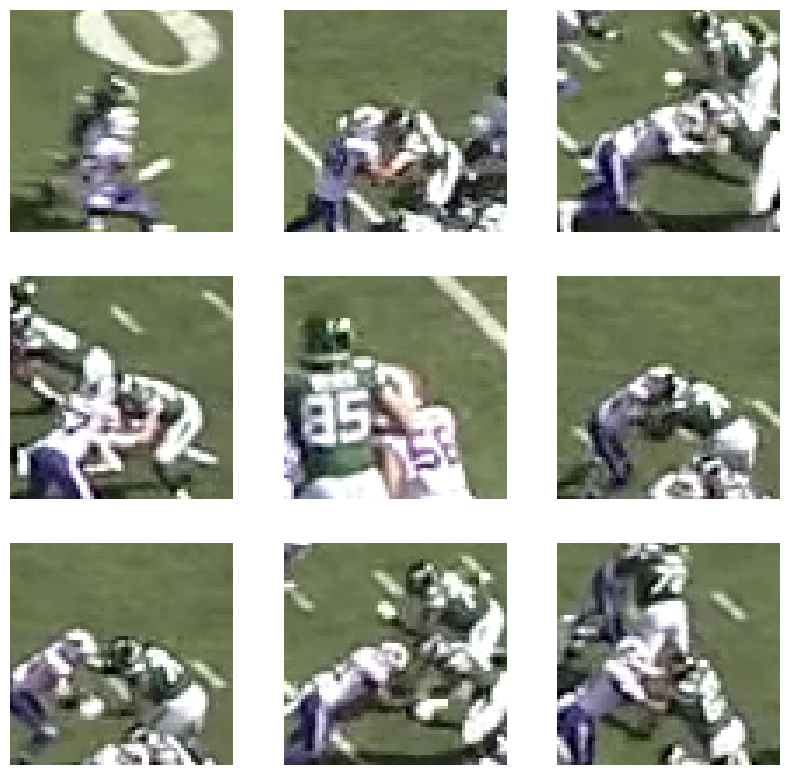

In [20]:
df_pred_vid = df_pred[df_pred["video"] == df_pred['video'].unique()[0]]

dataset = NFLDatasetClsInference(
    df_pred_vid,
    transforms=get_transfos_cls(train=False, visualize=True),
    root=DATA_ROOT_PATH,
)

plt.figure(figsize=(10, 10))
for i in range(9):
    
    plt.subplot(3, 3, i + 1)
    i = np.random.randint(len(dataset))
    plt.imshow(dataset[i].numpy().transpose(1, 2, 0))
    plt.axis(False)
    
plt.show()

## Model

In [21]:
def load_model_weights(model, filename, verbose=1, cp_folder=""):
    """
    Loads the weights of a PyTorch model. The exception handles cpu/gpu incompatibilities

    Arguments:
        model {torch module} -- Model to load the weights to
        filename {str} -- Name of the checkpoint

    Keyword Arguments:
        verbose {int} -- Whether to display infos (default: {1})
        cp_folder {str} -- Folder to load from (default: {''})

    Returns:
        torch module -- Model with loaded weights
    """
    if verbose:
        print(f"\n -> Loading weights from {os.path.join(cp_folder,filename)}\n")
    try:
        model.load_state_dict(os.path.join(cp_folder, filename), strict=False)
    except BaseException:
        model.load_state_dict(
            torch.load(os.path.join(cp_folder, filename), map_location="cpu"),
            strict=True,
        )
    return model

In [22]:
RESNETS = [
    "resnet18",
    "resnet34",
    "resnet50",
    "resnet101",
    "resnet152",
    "resnext50_32x4d",
    "resnext101_32x8d",
    "wide_resnet50_2",
    "wide_resnet101_2",
]


def get_model_cls(
    name, num_classes=1,
):
    """
    Loads a pretrained model.
    Supports Resnet based models.

    Args:
        name (str): Model name
        num_classes (int, optional): Number of classes. Defaults to 1.

    Raises:
        NotImplementedError: Specified model name is not supported.

    Returns:
        torch model -- Pretrained model.
    """

    # Load pretrained model
    if "resnest" in name:
        model = getattr(resnest_torch, name)(pretrained=False)
    elif name in RESNETS:
        model = getattr(torchvision.models, name)(pretrained=False)
    elif "efficientnet" in name:
        model = EfficientNet.from_name(name)
    else:
        raise NotImplementedError
    model.name = name

    if "efficientnet" not in name:
        model.conv1.stride = (1, 1)

        model.nb_ft = model.fc.in_features
        model.fc = nn.Linear(model.nb_ft, num_classes)

    else:
        model._conv_stem.stride = (1, 1)

        model.nb_ft = model._fc.in_features
        model._fc = nn.Linear(model.nb_ft, num_classes)

    model.num_classes = num_classes

    return model

In [23]:
def retrieve_model(config, fold=0, log_folder=""):
    model = get_model_cls(
        config['name'],
        num_classes=config['num_classes'],
    ).eval()
    model.zero_grad()

    model = load_model_weights(
        model,
        log_folder + f"{config['name']}_{fold}.pt"
    )

    return model

## Inference

In [24]:
def inference(df, models, batch_size=256, device="cuda", root=""):
    models = [model.to(device).eval() for model in models]

    dataset = dataset = NFLDatasetClsInference(
        df.copy(),
        transforms=get_transfos_cls(train=False),
        root=root,
    )

    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True,
    )

    preds = []
    with torch.no_grad():
        for img in loader:
            img = img.to(device)
            preds_img = []
            
            for model in models:
                y_pred = model(img)
                preds_img.append(y_pred.sigmoid().detach().cpu().numpy())
                
            preds.append(np.mean(preds_img, 0))
            
    return np.concatenate(preds)


## Main

### Data

In [25]:
df_pred["image_name"] = df_pred['video'].str.replace('.mp4', '') + '_' + df_pred['frame'].apply(lambda x: f'{x:04d}') + '.png'

images = df_pred["image_name"].unique()

### Models

In [26]:
CP_FOLDER = "../input/nfl-dataset-1/"

In [27]:
configs = {
    "efficientnet-b3": {
        "name": "efficientnet-b3",
        "num_classes": 1,
        "k": 5,
    },
#     "efficientnet-b2": {
#         "name": "efficientnet-b2",
#         "num_classes": 1,
#         "k": 5,
#     },
    "efficientnet-b1": {
        "name": "efficientnet-b1",
        "num_classes": 1,
        "k": 5,
    },
#     "efficientnet-b4": {
#         "name": "efficientnet-b4",
#         "num_classes": 1,
#         "k": 5,
#     },
    "resnet18": {
        "name": "resnet18",
        "num_classes": 1,
        "k": 5,
    },
#     "resnet34": {
#         "name": "resnet34",
#         "num_classes": 1,
#         "k": 5,
#     },
}


In [28]:
if CLS_2D>0:
    models = []
    for model in configs:
        n = 1 if DEBUG else configs[model]['k']
        models += [retrieve_model(configs[model], fold=k, log_folder=CP_FOLDER) for k in range(n)]
#       models += [retrieve_model(configs[model], fold=0, log_folder=CP_FOLDER)]

### Inference

In [29]:
if CLS_2D>0:
    preds = []
    for vid in tqdm(df_pred['video'].unique()):
        df_pred_vid = df_pred[df_pred["video"] == vid]

        pred = inference(df_pred_vid, models, root=DATA_ROOT_PATH)
        preds.append(pred)

In [30]:
if CLS_2D>0:
    df_pred['pred_cls'] = np.concatenate(preds)
else:
    df_pred['pred_cls'] = 0

In [31]:
if CLS_2D>0:
    del pred, preds, vid, df_pred_vid, models
    _ = gc.collect()
    torch.cuda.empty_cache()
    print('Cleared GPU VRAM')

# 3D Classification Models

In [32]:
import sys
sys.path.append('../input/mmaction2/mmaction2/mmaction2')

## Data

In [33]:
def extend_box(box, size=64):
    w = box[1] - box[0]
    h = box[3] - box[2]

    dw = (size - w) / 2
    dh = (size - h) / 2

    new_box = [
        box[0] - np.floor(dw),
        box[1] + np.ceil(dw),
        box[2] - np.floor(dh),
        box[3] + np.ceil(dh),
    ]
    return np.array(new_box).astype(int)


def adapt_to_shape(box, shape):
    if box[0] < 0:
        box[1] -= box[0]
        box[0] = 0
    elif box[1] >= shape[1]:
        diff = box[1] - shape[1]
        box[1] -= diff
        box[0] -= diff

    if box[2] < 0:
        box[3] -= box[2]
        box[2] = 0

    elif box[3] >= shape[0]:
        diff = box[3] - shape[0]
        box[3] -= diff
        box[2] -= diff

    return box


def get_adjacent_frames(frame, max_frame=100, n_frames=9, stride=1):
    frames = np.arange(n_frames) * stride
    frames = frames - frames[n_frames // 2] + frame

    if frames.min() < 1:
        frames -= frames.min() - 1
    elif frames.max() > max_frame:
        frames += max_frame - frames.max()

    return frames

In [34]:
class NFLDatasetClsInference3D(Dataset):
    def __init__(self, df, n_frames=9, stride=2, visualize=False, root=""):
        super().__init__()
        self.n_frames = n_frames
        self.stride = stride
        self.visualize = visualize
        self.root = root

        self.max_frame = df['nb_frame'].values[0]

        self.images = []

        image_name = df['image_name'].values[0].split('.')[0][:-4]
        self.images = [image_name + f'{f:04d}.png' for f in range(1, self.max_frame + 1)]

        self.images = [cv2.imread(self.root + img) for img in self.images]
        self.images = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in self.images]

        self.frame_to_img = list(df["frame"].unique())
        self.frames = df["frame"].values

        self.boxes = df[["left", "width", "top", "height"]].values
        self.boxes[:, 1] += self.boxes[:, 0]
        self.boxes[:, 3] += self.boxes[:, 2]

    def __len__(self):
        return len(self.boxes)

    def __getitem__(self, idx):
        frame = self.frames[idx]
        frames = get_adjacent_frames(
            frame, max_frame=self.max_frame, n_frames=self.n_frames, stride=self.stride
        )

        image = [self.images[f - 1] for f in frames]
        image = np.array(image)

        box = extend_box(self.boxes[idx], size=64)
        box = adapt_to_shape(box, image.shape[1:])

        image = image[:, box[2]: box[3], box[0]: box[1]]

        if not self.visualize:
            image = (image / 255 - 0.5) / 0.5
            image = image.transpose(3, 0, 1, 2)
            image = torch.from_numpy(image).float()

        return image

## Model

In [35]:
CP_PATHS = {
    "resnet18": DATA_PATH + "weights/r3d18_KM_200ep.pth",
    "resnet34": DATA_PATH + "weights/r3d34_KM_200ep.pth",
    "resnet50": DATA_PATH + "weights/r3d50_KMS_200ep.pth",
    "i3d": DATA_PATH + "weights/rgb_imagenet.pt",
    "slowfast": DATA_PATH + "weights/slowfast_r50_256p_4x16x1_256e_kinetics400_rgb.pth",
    "slowonly": DATA_PATH + "weights/slowonly_r50_omni_4x16x1_kinetics400_rgb.pth",
}

CONFIGS = {
    "slowfast": dict(
        type="Recognizer3D",
        backbone=dict(
            type="ResNet3dSlowFast",
            pretrained=None,
            resample_rate=8,  # tau
            speed_ratio=8,  # alpha
            channel_ratio=8,  # beta_inv
            slow_pathway=dict(
                type="resnet3d",
                depth=50,
                pretrained=None,
                lateral=True,
                conv1_kernel=(1, 7, 7),
                dilations=(1, 1, 1, 1),
                conv1_stride_t=1,
                pool1_stride_t=1,
                inflate=(0, 0, 1, 1),
                norm_eval=False,
            ),
            fast_pathway=dict(
                type="resnet3d",
                depth=50,
                pretrained=None,
                lateral=False,
                base_channels=8,
                conv1_kernel=(5, 7, 7),
                conv1_stride_t=1,
                pool1_stride_t=1,
                norm_eval=False,
            ),
        ),
        cls_head=dict(
            type="SlowFastHead",
            in_channels=2304,  # 2048+256
            num_classes=400,
            spatial_type="avg",
            dropout_ratio=0.5,
        ),
    ),
    "slowonly": dict(
        type="Recognizer3D",
        backbone=dict(
            type="ResNet3dSlowOnly",
            depth=50,
            pretrained=None,
            lateral=False,
            conv1_kernel=(1, 7, 7),
            conv1_stride_t=1,
            pool1_stride_t=1,
            inflate=(0, 0, 1, 1),
            norm_eval=False,
        ),
        cls_head=dict(
            type="I3DHead",
            in_channels=2048,
            num_classes=400,
            spatial_type="avg",
            dropout_ratio=0.5,
        ),
    ),
}


In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# import numpy as np


class MaxPool3dSamePadding(nn.MaxPool3d):
    def compute_pad(self, dim, s):
        if s % self.stride[dim] == 0:
            return max(self.kernel_size[dim] - self.stride[dim], 0)
        else:
            return max(self.kernel_size[dim] - (s % self.stride[dim]), 0)

    def forward(self, x):
        # compute 'same' padding
        (batch, channel, t, h, w) = x.size()
        # print t,h,w
        # out_t = np.ceil(float(t) / float(self.stride[0]))
        # out_h = np.ceil(float(h) / float(self.stride[1]))
        # out_w = np.ceil(float(w) / float(self.stride[2]))
        # print out_t, out_h, out_w
        pad_t = self.compute_pad(0, t)
        pad_h = self.compute_pad(1, h)
        pad_w = self.compute_pad(2, w)
        # print pad_t, pad_h, pad_w

        pad_t_f = pad_t // 2
        pad_t_b = pad_t - pad_t_f
        pad_h_f = pad_h // 2
        pad_h_b = pad_h - pad_h_f
        pad_w_f = pad_w // 2
        pad_w_b = pad_w - pad_w_f

        pad = (pad_w_f, pad_w_b, pad_h_f, pad_h_b, pad_t_f, pad_t_b)
        # print x.size()
        # print pad
        x = F.pad(x, pad)
        return super(MaxPool3dSamePadding, self).forward(x)


class Unit3D(nn.Module):
    def __init__(
        self,
        in_channels,
        output_channels,
        kernel_shape=(1, 1, 1),
        stride=(1, 1, 1),
        padding=0,
        activation_fn=F.relu,
        use_batch_norm=True,
        use_bias=False,
        name="unit_3d",
    ):

        """Initializes Unit3D module."""
        super(Unit3D, self).__init__()

        self._output_channels = output_channels
        self._kernel_shape = kernel_shape
        self._stride = stride
        self._use_batch_norm = use_batch_norm
        self._activation_fn = activation_fn
        self._use_bias = use_bias
        self.name = name
        self.padding = padding

        self.conv3d = nn.Conv3d(
            in_channels=in_channels,
            out_channels=self._output_channels,
            kernel_size=self._kernel_shape,
            stride=self._stride,
            padding=0,  # we always want padding to be 0 here.
            bias=self._use_bias,
        )

        if self._use_batch_norm:
            self.bn = nn.BatchNorm3d(self._output_channels, eps=0.001, momentum=0.01)

    def compute_pad(self, dim, s):
        if s % self._stride[dim] == 0:
            return max(self._kernel_shape[dim] - self._stride[dim], 0)
        else:
            return max(self._kernel_shape[dim] - (s % self._stride[dim]), 0)

    def forward(self, x):
        # compute 'same' padding
        (batch, channel, t, h, w) = x.size()
        # print t,h,w
        # out_t = np.ceil(float(t) / float(self._stride[0]))
        # out_h = np.ceil(float(h) / float(self._stride[1]))
        # out_w = np.ceil(float(w) / float(self._stride[2]))
        # print out_t, out_h, out_w
        pad_t = self.compute_pad(0, t)
        pad_h = self.compute_pad(1, h)
        pad_w = self.compute_pad(2, w)
        # print pad_t, pad_h, pad_w

        pad_t_f = pad_t // 2
        pad_t_b = pad_t - pad_t_f
        pad_h_f = pad_h // 2
        pad_h_b = pad_h - pad_h_f
        pad_w_f = pad_w // 2
        pad_w_b = pad_w - pad_w_f

        pad = (pad_w_f, pad_w_b, pad_h_f, pad_h_b, pad_t_f, pad_t_b)
        # print x.size()
        # print pad
        x = F.pad(x, pad)
        # print x.size()

        x = self.conv3d(x)
        if self._use_batch_norm:
            x = self.bn(x)
        if self._activation_fn is not None:
            x = self._activation_fn(x)
        return x


class InceptionModule(nn.Module):
    def __init__(self, in_channels, out_channels, name):
        super(InceptionModule, self).__init__()

        self.b0 = Unit3D(
            in_channels=in_channels,
            output_channels=out_channels[0],
            kernel_shape=[1, 1, 1],
            padding=0,
            name=name + "/Branch_0/Conv3d_0a_1x1",
        )
        self.b1a = Unit3D(
            in_channels=in_channels,
            output_channels=out_channels[1],
            kernel_shape=[1, 1, 1],
            padding=0,
            name=name + "/Branch_1/Conv3d_0a_1x1",
        )
        self.b1b = Unit3D(
            in_channels=out_channels[1],
            output_channels=out_channels[2],
            kernel_shape=[3, 3, 3],
            name=name + "/Branch_1/Conv3d_0b_3x3",
        )
        self.b2a = Unit3D(
            in_channels=in_channels,
            output_channels=out_channels[3],
            kernel_shape=[1, 1, 1],
            padding=0,
            name=name + "/Branch_2/Conv3d_0a_1x1",
        )
        self.b2b = Unit3D(
            in_channels=out_channels[3],
            output_channels=out_channels[4],
            kernel_shape=[3, 3, 3],
            name=name + "/Branch_2/Conv3d_0b_3x3",
        )
        self.b3a = MaxPool3dSamePadding(
            kernel_size=[3, 3, 3], stride=(1, 1, 1), padding=0
        )
        self.b3b = Unit3D(
            in_channels=in_channels,
            output_channels=out_channels[5],
            kernel_shape=[1, 1, 1],
            padding=0,
            name=name + "/Branch_3/Conv3d_0b_1x1",
        )
        self.name = name

    def forward(self, x):
        b0 = self.b0(x)
        b1 = self.b1b(self.b1a(x))
        b2 = self.b2b(self.b2a(x))
        b3 = self.b3b(self.b3a(x))
        return torch.cat([b0, b1, b2, b3], dim=1)


class InceptionI3d(nn.Module):
    """Inception-v1 I3D architecture.
    The model is introduced in:
        Quo Vadis, Action Recognition? A New Model and the Kinetics Dataset
        Joao Carreira, Andrew Zisserman
        https://arxiv.org/pdf/1705.07750v1.pdf.
    See also the Inception architecture, introduced in:
        Going deeper with convolutions
        Christian Szegedy, Wei Liu, Yangqing Jia, Pierre Sermanet, Scott Reed,
        Dragomir Anguelov, Dumitru Erhan, Vincent Vanhoucke, Andrew Rabinovich.
        http://arxiv.org/pdf/1409.4842v1.pdf.
    """

    # Endpoints of the model in order. During construction, all the endpoints up
    # to a designated `final_endpoint` are returned in a dictionary as the
    # second return value.
    VALID_ENDPOINTS = (
        "Conv3d_1a_7x7",
        "MaxPool3d_2a_3x3",
        "Conv3d_2b_1x1",
        "Conv3d_2c_3x3",
        "MaxPool3d_3a_3x3",
        "Mixed_3b",
        "Mixed_3c",
        "MaxPool3d_4a_3x3",
        "Mixed_4b",
        "Mixed_4c",
        "Mixed_4d",
        "Mixed_4e",
        "Mixed_4f",
        "MaxPool3d_5a_2x2",
        "Mixed_5b",
        "Mixed_5c",
        "Logits",
        "Predictions",
    )

    def __init__(
        self,
        num_classes=400,
        spatial_squeeze=True,
        final_endpoint="Logits",
        name="inception_i3d",
        in_channels=3,
        dropout_keep_prob=0.5,
    ):
        """Initializes I3D model instance.
        Args:
          num_classes: The number of outputs in the logit layer (default 400, which
              matches the Kinetics dataset).
          spatial_squeeze: Whether to squeeze the spatial dimensions for the logits
              before returning (default True).
          final_endpoint: The model contains many possible endpoints.
              `final_endpoint` specifies the last endpoint for the model to be built
              up to. In addition to the output at `final_endpoint`, all the outputs
              at endpoints up to `final_endpoint` will also be returned, in a
              dictionary. `final_endpoint` must be one of
              InceptionI3d.VALID_ENDPOINTS (default 'Logits').
          name: A string (optional). The name of this module.
        Raises:
          ValueError: if `final_endpoint` is not recognized.
        """

        if final_endpoint not in self.VALID_ENDPOINTS:
            raise ValueError("Unknown final endpoint %s" % final_endpoint)

        super(InceptionI3d, self).__init__()
        self._num_classes = num_classes
        self._spatial_squeeze = spatial_squeeze
        self._final_endpoint = final_endpoint
        self.logits = None

        if self._final_endpoint not in self.VALID_ENDPOINTS:
            raise ValueError("Unknown final endpoint %s" % self._final_endpoint)

        self.end_points = {}
        end_point = "Conv3d_1a_7x7"
        self.end_points[end_point] = Unit3D(
            in_channels=in_channels,
            output_channels=64,
            kernel_shape=[7, 7, 7],
            stride=(2, 2, 2),
            padding=(3, 3, 3),
            name=name + end_point,
        )
        if self._final_endpoint == end_point:
            return

        end_point = "MaxPool3d_2a_3x3"
        self.end_points[end_point] = MaxPool3dSamePadding(
            kernel_size=[1, 3, 3], stride=(1, 2, 2), padding=0
        )
        if self._final_endpoint == end_point:
            return

        end_point = "Conv3d_2b_1x1"
        self.end_points[end_point] = Unit3D(
            in_channels=64,
            output_channels=64,
            kernel_shape=[1, 1, 1],
            padding=0,
            name=name + end_point,
        )
        if self._final_endpoint == end_point:
            return

        end_point = "Conv3d_2c_3x3"
        self.end_points[end_point] = Unit3D(
            in_channels=64,
            output_channels=192,
            kernel_shape=[3, 3, 3],
            padding=1,
            name=name + end_point,
        )
        if self._final_endpoint == end_point:
            return

        end_point = "MaxPool3d_3a_3x3"
        self.end_points[end_point] = MaxPool3dSamePadding(
            kernel_size=[1, 3, 3], stride=(1, 2, 2), padding=0
        )
        if self._final_endpoint == end_point:
            return

        end_point = "Mixed_3b"
        self.end_points[end_point] = InceptionModule(
            192, [64, 96, 128, 16, 32, 32], name + end_point
        )
        if self._final_endpoint == end_point:
            return

        end_point = "Mixed_3c"
        self.end_points[end_point] = InceptionModule(
            256, [128, 128, 192, 32, 96, 64], name + end_point
        )
        if self._final_endpoint == end_point:
            return

        end_point = "MaxPool3d_4a_3x3"
        self.end_points[end_point] = MaxPool3dSamePadding(
            kernel_size=[3, 3, 3], stride=(2, 2, 2), padding=0
        )
        if self._final_endpoint == end_point:
            return

        end_point = "Mixed_4b"
        self.end_points[end_point] = InceptionModule(
            128 + 192 + 96 + 64, [192, 96, 208, 16, 48, 64], name + end_point
        )
        if self._final_endpoint == end_point:
            return

        end_point = "Mixed_4c"
        self.end_points[end_point] = InceptionModule(
            192 + 208 + 48 + 64, [160, 112, 224, 24, 64, 64], name + end_point
        )
        if self._final_endpoint == end_point:
            return

        end_point = "Mixed_4d"
        self.end_points[end_point] = InceptionModule(
            160 + 224 + 64 + 64, [128, 128, 256, 24, 64, 64], name + end_point
        )
        if self._final_endpoint == end_point:
            return

        end_point = "Mixed_4e"
        self.end_points[end_point] = InceptionModule(
            128 + 256 + 64 + 64, [112, 144, 288, 32, 64, 64], name + end_point
        )
        if self._final_endpoint == end_point:
            return

        end_point = "Mixed_4f"
        self.end_points[end_point] = InceptionModule(
            112 + 288 + 64 + 64, [256, 160, 320, 32, 128, 128], name + end_point
        )
        if self._final_endpoint == end_point:
            return

        end_point = "MaxPool3d_5a_2x2"
        self.end_points[end_point] = MaxPool3dSamePadding(
            kernel_size=[2, 2, 2], stride=(2, 2, 2), padding=0
        )
        if self._final_endpoint == end_point:
            return

        end_point = "Mixed_5b"
        self.end_points[end_point] = InceptionModule(
            256 + 320 + 128 + 128, [256, 160, 320, 32, 128, 128], name + end_point
        )
        if self._final_endpoint == end_point:
            return

        end_point = "Mixed_5c"
        self.end_points[end_point] = InceptionModule(
            256 + 320 + 128 + 128, [384, 192, 384, 48, 128, 128], name + end_point
        )
        if self._final_endpoint == end_point:
            return

        end_point = "Logits"
        self.avg_pool = nn.AdaptiveAvgPool3d((1, 1, 1))

        self.dropout = nn.Dropout(dropout_keep_prob)
        self.logits = Unit3D(
            in_channels=384 + 384 + 128 + 128,
            output_channels=self._num_classes,
            kernel_shape=[1, 1, 1],
            padding=0,
            activation_fn=None,
            use_batch_norm=False,
            use_bias=True,
            name="logits",
        )

        self.build()

    def replace_logits(self, num_classes):
        self._num_classes = num_classes
        self.logits = Unit3D(
            in_channels=384 + 384 + 128 + 128,
            output_channels=self._num_classes,
            kernel_shape=[1, 1, 1],
            padding=0,
            activation_fn=None,
            use_batch_norm=False,
            use_bias=True,
            name="logits",
        )

    def build(self):
        for k in self.end_points.keys():
            self.add_module(k, self.end_points[k])

    def forward(self, x):
        x = self.extract_features(x)
        x = self.dropout(x.view(x.size(0), -1))

        y = self.logits(x)
        if self.num_classes_aux > 0:
            y_aux = self.fc_aux(x)
            return y, y_aux

        return y, 0

    def extract_features(self, x):
        for end_point in self.VALID_ENDPOINTS:
            if end_point in self.end_points:
                x = self._modules[end_point](x)

        # print(x.size())
        return self.avg_pool(x)


In [37]:
from functools import partial

import torch
import torch.nn as nn
import torch.nn.functional as F


def get_inplanes():
    return [64, 128, 256, 512]


def conv3x3x3(in_planes, out_planes, stride=1):
    return nn.Conv3d(
        in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False
    )


def conv1x1x1(in_planes, out_planes, stride=1):
    return nn.Conv3d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()

        self.conv1 = conv3x3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm3d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3x3(planes, planes)
        self.bn2 = nn.BatchNorm3d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()

        self.conv1 = conv1x1x1(in_planes, planes)
        self.bn1 = nn.BatchNorm3d(planes)
        self.conv2 = conv3x3x3(planes, planes, stride)
        self.bn2 = nn.BatchNorm3d(planes)
        self.conv3 = conv1x1x1(planes, planes * self.expansion)
        self.bn3 = nn.BatchNorm3d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(
        self,
        block,
        layers,
        block_inplanes,
        n_input_channels=3,
        conv1_t_size=7,
        conv1_t_stride=1,
        no_max_pool=False,
        shortcut_type="B",
        widen_factor=1.0,
        n_classes=400,
    ):
        super().__init__()

        block_inplanes = [int(x * widen_factor) for x in block_inplanes]

        self.in_planes = block_inplanes[0]
        self.no_max_pool = no_max_pool

        self.conv1 = nn.Conv3d(
            n_input_channels,
            self.in_planes,
            kernel_size=(conv1_t_size, 7, 7),
            stride=(conv1_t_stride, 2, 2),
            padding=(conv1_t_size // 2, 3, 3),
            bias=False,
        )
        self.bn1 = nn.BatchNorm3d(self.in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(
            block, block_inplanes[0], layers[0], shortcut_type
        )
        self.layer2 = self._make_layer(
            block, block_inplanes[1], layers[1], shortcut_type, stride=2
        )
        self.layer3 = self._make_layer(
            block, block_inplanes[2], layers[2], shortcut_type, stride=2
        )
        self.layer4 = self._make_layer(
            block, block_inplanes[3], layers[3], shortcut_type, stride=2
        )

        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(block_inplanes[3] * block.expansion, n_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _downsample_basic_block(self, x, planes, stride):
        out = F.avg_pool3d(x, kernel_size=1, stride=stride)
        zero_pads = torch.zeros(
            out.size(0), planes - out.size(1), out.size(2), out.size(3), out.size(4)
        )
        if isinstance(out.data, torch.cuda.FloatTensor):
            zero_pads = zero_pads.cuda()

        out = torch.cat([out.data, zero_pads], dim=1)

        return out

    def _make_layer(self, block, planes, blocks, shortcut_type, stride=1):
        downsample = None
        if stride != 1 or self.in_planes != planes * block.expansion:
            if shortcut_type == "A":
                downsample = partial(
                    self._downsample_basic_block,
                    planes=planes * block.expansion,
                    stride=stride,
                )
            else:
                downsample = nn.Sequential(
                    conv1x1x1(self.in_planes, planes * block.expansion, stride),
                    nn.BatchNorm3d(planes * block.expansion),
                )

        layers = []
        layers.append(
            block(
                in_planes=self.in_planes,
                planes=planes,
                stride=stride,
                downsample=downsample,
            )
        )
        self.in_planes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.in_planes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        if not self.no_max_pool:
            x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)

        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


def generate_model(model_depth, **kwargs):
    assert model_depth in [10, 18, 34, 50, 101, 152, 200]

    if model_depth == 10:
        model = ResNet(BasicBlock, [1, 1, 1, 1], get_inplanes(), **kwargs)
    elif model_depth == 18:
        model = ResNet(BasicBlock, [2, 2, 2, 2], get_inplanes(), **kwargs)
    elif model_depth == 34:
        model = ResNet(BasicBlock, [3, 4, 6, 3], get_inplanes(), **kwargs)
    elif model_depth == 50:
        model = ResNet(Bottleneck, [3, 4, 6, 3], get_inplanes(), **kwargs)
    elif model_depth == 101:
        model = ResNet(Bottleneck, [3, 4, 23, 3], get_inplanes(), **kwargs)
    elif model_depth == 152:
        model = ResNet(Bottleneck, [3, 8, 36, 3], get_inplanes(), **kwargs)
    elif model_depth == 200:
        model = ResNet(Bottleneck, [3, 24, 36, 3], get_inplanes(), **kwargs)

    return model

def forward_with_aux_resnet_3d(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    if not self.no_max_pool:
        x = self.maxpool(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)

    x = self.avgpool(x)

    x = x.view(x.size(0), -1)
    y = self.fc(x)

    if self.num_classes_aux > 0:
        y_aux = self.fc_aux(x)
        return y, y_aux

    return y, 0

In [38]:
def forward_slowfast(self, x):
    x = x[:, :, 1:, :, :]  # size BS x 8 x C x W x H
    ft1, ft2 = self.extract_feat(x)

    ft1 = self.avg_pool(ft1).view(x.size(0), -1)
    ft2 = self.avg_pool(ft2).view(x.size(0), -1)

    ft = torch.cat([ft1, ft2], -1)
    ft = self.dropout(ft)

    y = self.fc(ft)

    if self.num_classes_aux > 0:
        y_aux = self.fc_aux(ft)
        return y, y_aux

    return y, 0


def forward_slowonly(self, x):
    ft = self.extract_feat(x)
    # print(ft.size())

    ft = self.avg_pool(ft).view(x.size(0), -1)
    ft = self.dropout(ft)

    y = self.fc(ft)

    if self.num_classes_aux > 0:
        y_aux = self.fc_aux(ft)
        return y, y_aux

    return y, 0

In [39]:
import mmaction
from mmaction.models import build_model
from mmcv.runner import load_checkpoint


def get_model_cls_3d(name, num_classes=1, num_classes_aux=0, pretrained=False):
    """
    Loads a pretrained model.
    Supports Resnet based models.

    Args:
        name (str): Model name
        num_classes (int, optional): Number of classes. Defaults to 1.

    Raises:
        NotImplementedError: Specified model name is not supported.

    Returns:
        torch model -- Pretrained model.
    """

    # Load pretrained model
    if "resnet" in name:
        n_classes = 1139 if "KMS" in CP_PATHS[name] else 1039
        depth = int(name[-2:])
        model = generate_model(depth, n_classes=n_classes)

        if pretrained:
            load_model_weights_3d(model, CP_PATHS[name])
    elif name == "i3d":  # i3d
        model = InceptionI3d(num_classes=400, in_channels=3)

        if pretrained:
            load_model_weights(model, CP_PATHS[name])

    elif name in ["slowfast", "slowonly"]:
        model = build_model(CONFIGS[name])

        if pretrained:
            print(f'\n -> Loading weighs from "{CP_PATHS[name]}"\n')
            load_checkpoint(model, CP_PATHS[name])
    else:
        raise NotImplementedError

    model.name = name
    model.num_classes = num_classes
    model.num_classes_aux = num_classes_aux

    if "resnet" in name:
        # Strides
        model.conv1.stride = (1, 1, 1)
        model.layer2[0].conv1.stride = (1, 2, 2)
        model.layer2[0].downsample[0].stride = (1, 2, 2)
        model.layer3[0].conv1.stride = (1, 2, 2)
        model.layer3[0].downsample[0].stride = (1, 2, 2)
        model.layer4[0].conv1.stride = (1, 2, 2)
        model.layer4[0].downsample[0].stride = (1, 2, 2)
        model.maxpool.stride = (1, 2, 2)

        model.nb_ft = model.fc.in_features
        model.fc = nn.Linear(model.nb_ft, num_classes)
        model.forward = lambda x: forward_with_aux_resnet_3d(model, x)

        if num_classes_aux:
            model.fc_aux = nn.Linear(model.nb_ft, num_classes_aux)

    elif name == "i3d":
        model.Conv3d_1a_7x7.conv3d.stride = (1, 1, 1)
        # model.MaxPool3d_2a_3x3.stride = (1, 1, 1)
        model.MaxPool3d_4a_3x3.stride = (1, 2, 2)
        model.MaxPool3d_5a_2x2.stride = (1, 2, 2)

        model.nb_ft = model.logits.conv3d.in_channels
        model.logits = nn.Linear(model.nb_ft, num_classes)

        if num_classes_aux:
            model.fc_aux = nn.Linear(model.nb_ft, num_classes_aux)

    elif name == "slowfast":
        model.backbone.slow_path.conv1.stride = (1, 1, 1)
        model.backbone.fast_path.conv1.stride = (1, 1, 1)

        model.backbone.slow_path.maxpool.stride = (1, 1, 1)
        model.backbone.fast_path.maxpool.stride = (1, 1, 1)

        model.backbone.slow_path.pool2.stride = (1, 1, 1)
        model.backbone.fast_path.pool2.stride = (1, 1, 1)

        model.dropout = nn.Dropout(0.5)
        model.avg_pool = nn.AdaptiveAvgPool3d((1, 1, 1))

        model.nb_ft = model.cls_head.fc_cls.in_features

        model.fc = nn.Linear(model.nb_ft, num_classes)
        model.forward = lambda x: forward_slowfast(model, x)

        if num_classes_aux:
            model.fc_aux = nn.Linear(model.nb_ft, num_classes_aux)

    else:
        model.backbone.conv1.stride = (1, 1, 1)
        model.backbone.pool2.stride = (1, 1, 1)
        model.backbone.maxpool.stride = (1, 1, 1)

        model.dropout = nn.Dropout(0.5)
        model.avg_pool = nn.AdaptiveAvgPool3d((1, 1, 1))

        model.nb_ft = model.cls_head.fc_cls.in_features

        model.fc = nn.Linear(model.nb_ft, num_classes)
        model.forward = lambda x: forward_slowonly(model, x)

        if num_classes_aux:
            model.fc_aux = nn.Linear(model.nb_ft, num_classes_aux)

    return model

In [40]:
def retrieve_model(config, fold=0, log_folder=""):
    model = get_model_cls_3d(
        config["name"],
        num_classes=config["num_classes"],
        num_classes_aux=config["num_classes_aux"],
        pretrained=False
    ).eval()
    model.zero_grad()

    model = load_model_weights(model, log_folder + f"{config['name']}_{fold}.pt")

    return model

## Inference

In [41]:
def inference(df, models, batch_size=256, device="cuda", root="", n_frames=9, stride=2):
    models = [model.to(device).eval() for model in models]

    dataset = NFLDatasetClsInference3D(
        df.copy(),
        root=root,
        n_frames=n_frames,
        stride=stride,
    )

    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True,
    )

    preds = []
    with torch.no_grad():
        for img in loader:
            img = img.to(device)
            preds_img = []

            for model in models:
                y_pred = model(img)[0]
                preds_img.append(y_pred.sigmoid().detach().cpu().numpy())

            preds.append(np.mean(preds_img, 0))

    return np.concatenate(preds)


## Main

In [42]:
if "nb_frame" not in df_pred.columns:
    df_frames = pd.DataFrame(os.listdir(DATA_ROOT_PATH), columns=["name"])
    df_frames['frame'] = df_frames['name'].apply(lambda x: int(x[-8:-4]))
    df_frames['video'] = df_frames['name'].apply(lambda x: "_".join(x.split('_')[:3]) + ".mp4")

    df_max_frame = df_frames[['video', 'frame']].groupby('video').max().rename(columns={"frame": "nb_frame"}).reset_index()

    df_pred = df_pred.merge(df_max_frame, on="video")

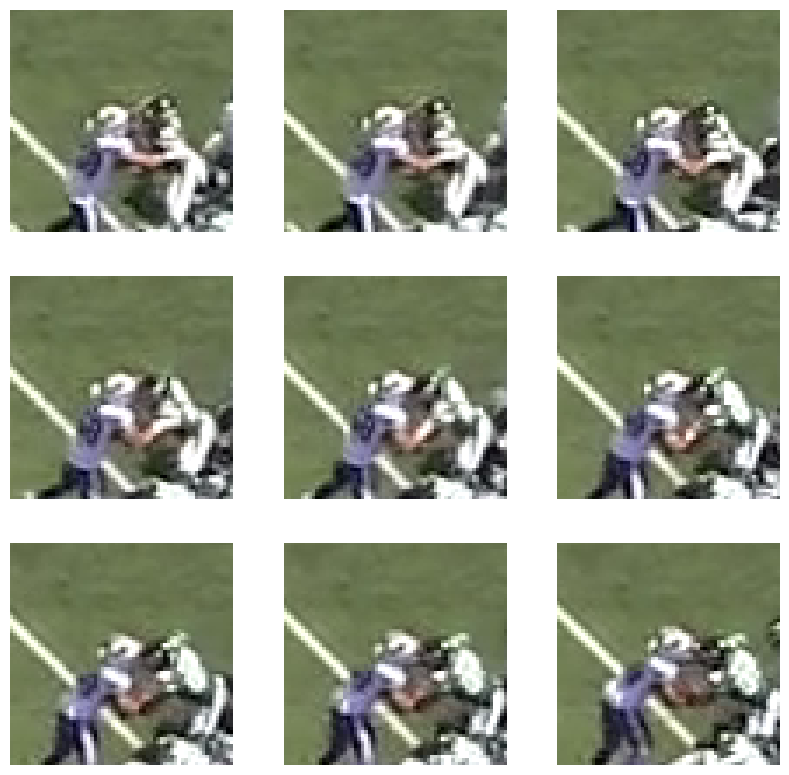

In [43]:
df_pred_vid = df_pred[df_pred["video"] == df_pred['video'].unique()[0]]

dataset = NFLDatasetClsInference3D(
    df_pred_vid,
    visualize=True,
    stride=2,
    n_frames=9,
    root=DATA_ROOT_PATH,
)

for i in np.random.choice(len(dataset), 1):
    image = dataset[i]

    plt.figure(figsize=(10, 10))
    for i, img in enumerate(image):
        plt.subplot(3, 3, i+1)
        plt.imshow(img)
        plt.axis(False)
    plt.show()

In [44]:
CP_FOLDER = "../input/nfl-dataset-3/"

configs_r18 = {
    "30_0": {
        "name": "resnet18",
        "num_classes": 1,
        "num_classes_aux": 0,
        "k": 5,
        "stride": 2,
        "num_frames": 9
    },
    "30_8": {
        "name": "resnet18",
        "num_classes": 1,
        "num_classes_aux": 0,
        "k": 5,
        "stride": 2,
        "num_frames": 9
    },
    "31_0": {
        "name": "resnet18",
        "num_classes": 1,
        "num_classes_aux": 4,
        "k": 5,
        "stride": 2,
        "num_frames": 9
    },
    "31_1": {
        "name": "resnet34",
        "num_classes": 1,
        "num_classes_aux": 0,
        "k": 5,
        "stride": 2,
        "num_frames": 9
    },
}

configs = {
    "03_5": {
        "name": "i3d",
        "num_classes": 1,
        "num_classes_aux": 0,
        "k": 5,
        "stride": 2,
        "num_frames": 9
    },
    "03_1": {
        "name": "slowonly",
        "num_classes": 1,
        "num_classes_aux": 0,
        "k": 5,
        "stride": 2,
        "num_frames": 9
    },
    "03_2": {
        "name": "slowfast",
        "num_classes": 1,
        "num_classes_aux": 0,
        "k": 5,
        "stride": 2,
        "num_frames": 9
    },
}

In [45]:
models = []

for name in configs_r18:
    path = CP_FOLDER + name + "/" + name[-1] + "/"
    n = 1 if DEBUG else configs_r18[name]['k']
    models += [retrieve_model(configs_r18[name], fold=i, log_folder=path) for i in range(n)]
    
preds = []
for vid in tqdm(df_pred['video'].unique()):
    df_pred_vid = df_pred[df_pred["video"] == vid]

    pred = inference(df_pred_vid, models, root=DATA_ROOT_PATH, stride=2, n_frames=9, batch_size=16)
    preds.append(pred)
    
df_pred['pred_cls_3d_r18'] = np.concatenate(preds)


 -> Loading weights from ../input/nfl-dataset-3/30_0/0/resnet18_0.pt


 -> Loading weights from ../input/nfl-dataset-3/30_0/0/resnet18_1.pt


 -> Loading weights from ../input/nfl-dataset-3/30_0/0/resnet18_2.pt


 -> Loading weights from ../input/nfl-dataset-3/30_0/0/resnet18_3.pt


 -> Loading weights from ../input/nfl-dataset-3/30_0/0/resnet18_4.pt


 -> Loading weights from ../input/nfl-dataset-3/30_8/8/resnet18_0.pt


 -> Loading weights from ../input/nfl-dataset-3/30_8/8/resnet18_1.pt


 -> Loading weights from ../input/nfl-dataset-3/30_8/8/resnet18_2.pt


 -> Loading weights from ../input/nfl-dataset-3/30_8/8/resnet18_3.pt


 -> Loading weights from ../input/nfl-dataset-3/30_8/8/resnet18_4.pt


 -> Loading weights from ../input/nfl-dataset-3/31_0/0/resnet18_0.pt


 -> Loading weights from ../input/nfl-dataset-3/31_0/0/resnet18_1.pt


 -> Loading weights from ../input/nfl-dataset-3/31_0/0/resnet18_2.pt


 -> Loading weights from ../input/nfl-dataset-3/31_0/0/resnet18_3.pt


 -> L

In [46]:
del pred, preds, vid, df_pred_vid, models
_ = gc.collect()
torch.cuda.empty_cache()
print('Cleared GPU VRAM')

Cleared GPU VRAM


In [47]:
models = []

for name in configs:
    path = CP_FOLDER + name + "/" + name[-1] + "/"
    n = 1 if DEBUG else configs[name]['k']
    models += [retrieve_model(configs[name], fold=i, log_folder=path) for i in range(n)]
    
preds = []
for vid in tqdm(df_pred['video'].unique()):
    df_pred_vid = df_pred[df_pred["video"] == vid]

    pred = inference(df_pred_vid, models, root=DATA_ROOT_PATH, stride=2, n_frames=9, batch_size=16)
    preds.append(pred)
    
df_pred['pred_cls_3d'] = np.concatenate(preds)


 -> Loading weights from ../input/nfl-dataset-3/03_5/5/i3d_0.pt


 -> Loading weights from ../input/nfl-dataset-3/03_5/5/i3d_1.pt


 -> Loading weights from ../input/nfl-dataset-3/03_5/5/i3d_2.pt


 -> Loading weights from ../input/nfl-dataset-3/03_5/5/i3d_3.pt


 -> Loading weights from ../input/nfl-dataset-3/03_5/5/i3d_4.pt


 -> Loading weights from ../input/nfl-dataset-3/03_1/1/slowonly_0.pt


 -> Loading weights from ../input/nfl-dataset-3/03_1/1/slowonly_1.pt


 -> Loading weights from ../input/nfl-dataset-3/03_1/1/slowonly_2.pt


 -> Loading weights from ../input/nfl-dataset-3/03_1/1/slowonly_3.pt


 -> Loading weights from ../input/nfl-dataset-3/03_1/1/slowonly_4.pt


 -> Loading weights from ../input/nfl-dataset-3/03_2/2/slowfast_0.pt


 -> Loading weights from ../input/nfl-dataset-3/03_2/2/slowfast_1.pt


 -> Loading weights from ../input/nfl-dataset-3/03_2/2/slowfast_2.pt


 -> Loading weights from ../input/nfl-dataset-3/03_2/2/slowfast_3.pt


 -> Loading weights from ../in

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


In [48]:
del pred, preds, vid, df_pred_vid, models
_ = gc.collect()
torch.cuda.empty_cache()
print('Cleared GPU VRAM')

Cleared GPU VRAM


In [49]:
df_pred["pred_cls_blend"] = (CLS_3D_NEW * df_pred['pred_cls_3d'] +  CLS_2D * df_pred['pred_cls'] 
                             + CLS_3D_OLD * df_pred['pred_cls_3d_r18']) / (CLS_3D_NEW + CLS_2D + CLS_3D_OLD)

In [50]:
df_pred

,gameKey,playID,view,video,frame,left,width,top,height,scores,image_name,pred_cls,nb_frame,pred_cls_3d_r18,pred_cls_3d,pred_cls_blend
0,57906,718,Sideline,57906_000718_Sideline.mp4,1,791,8,375,7,0.438849,57906_000718_Sideline_0001.png,0,440,0.009774,0.006678,0.007710
1,57906,718,Sideline,57906_000718_Sideline.mp4,1,794,8,365,9,0.362908,57906_000718_Sideline_0001.png,0,440,0.015601,0.003486,0.007524
2,57906,718,Sideline,57906_000718_Sideline.mp4,2,791,8,375,7,0.472634,57906_000718_Sideline_0002.png,0,440,0.009774,0.006678,0.007710
3,57906,718,Sideline,57906_000718_Sideline.mp4,2,794,8,365,9,0.386677,57906_000718_Sideline_0002.png,0,440,0.015601,0.003486,0.007524
4,57906,718,Sideline,57906_000718_Sideline.mp4,3,791,8,375,7,0.451342,57906_000718_Sideline_0003.png,0,440,0.009774,0.006678,0.007710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2459,58102,2798,Endzone,58102_002798_Endzone.mp4,363,763,36,402,35,0.390723,58102_002798_Endzone_0363.png,0,366,0.010799,0.002763,0.005441
2460,58102,2798,Endzone,58102_002798_Endzone.mp4,363,785,24,390,26,0.259023,58102_002798_Endzone_0363.png,0,366,0.050014,0.048932,0.049293
2461,58102,2798,Endzone,58102_002798_Endzone.mp4,364,762,36,402,35,0.377647,58102_002798_Endzone_0364.png,0,366,0.014246,0.002890,0.006676
2462,58102,2798,Endzone,58102_002798_Endzone.mp4,365,762,36,403,33,0.334263,58102_002798_Endzone_0365.png,0,366,0.014246,0.002890,0.006676


# Thresholding

In [51]:
df_pred1 = df_pred.loc[
    (df_pred.scores > DET_THRESHOLD)
    & (df_pred.frame <= SWITCH_FRAME)
    & (df_pred.view == "Endzone")
]
df_pred2 = df_pred.loc[
    (df_pred.scores > DET_THRESHOLD2)
    & (df_pred.frame > SWITCH_FRAME)
    & (df_pred.view == "Endzone")
]
df_pred3 = df_pred.loc[
    (df_pred.scores > DET_THRESHOLD - DELTA_DET)
    & (df_pred.frame <= SWITCH_FRAME)
    & (df_pred.view == "Sideline")
]
df_pred4 = df_pred.loc[
    (df_pred.scores > DET_THRESHOLD2 - DELTA_DET)
    & (df_pred.frame > SWITCH_FRAME)
    & (df_pred.view == "Sideline")
]
df_pred = pd.concat([df_pred1, df_pred2, df_pred3, df_pred4], axis=0)


In [52]:
print(f'Detected {len(df_pred)} impacts after detection thresholding')

Detected 1677 impacts after detection thresholding


In [53]:
df_pred_cls1 = df_pred.copy()[
    (df_pred["pred_cls_blend"] > CLS_THRESHOLD)
    & (df_pred.frame <= SWITCH_FRAME)
    & (df_pred.view == "Endzone")
]
df_pred_cls2 = df_pred.copy()[
    (df_pred["pred_cls_blend"] > CLS_THRESHOLD2)
    & (df_pred.frame > SWITCH_FRAME)
    & (df_pred.view == "Endzone")
]
df_pred_cls3 = df_pred.copy()[
    (df_pred["pred_cls_blend"] > CLS_THRESHOLD - DELTA_CLS)
    & (df_pred.frame <= SWITCH_FRAME)
    & (df_pred.view == "Sideline")
]
df_pred_cls4 = df_pred.copy()[
    (df_pred["pred_cls_blend"] > CLS_THRESHOLD2 - DELTA_CLS)
    & (df_pred.frame > SWITCH_FRAME)
    & (df_pred.view == "Sideline")
]
df_pred_cls = pd.concat(
    [df_pred_cls1, df_pred_cls2, df_pred_cls3, df_pred_cls4], axis=0
).reset_index(drop=True)


In [54]:
print(f'Detected {len(df_pred_cls)} impacts after classification thresholding')

Detected 847 impacts after classification thresholding


# Post-processing

## Metric

In [55]:
import numpy as np
from scipy.optimize import linear_sum_assignment


def get_boxes_from_df(df, videos):
    try:
        cols = ["frame", "video", "x", "w", "y", "h"]
        df = df[cols].groupby("video").agg(list)
    except KeyError:
        cols = ["frame", "video", "left", "width", "top", "height"]
        df = df[cols].groupby("video").agg(list)

    boxes = []

    for video in videos:
        try:
            frames, x, w, y, h = df.loc[video]
            boxes_pred = np.concatenate([
                np.array(frames)[:, None],
                np.array(x)[:, None],
                np.array(y)[:, None],
                np.array(w)[:, None] + np.array(x)[:, None],
                np.array(h)[:, None] + np.array(y)[:, None],
            ], -1)
            boxes.append(boxes_pred)
        except KeyError:
            boxes.append([])
    return boxes


def iou_score(bbox1, bbox2):
    bbox1 = [float(x) for x in bbox1]
    bbox2 = [float(x) for x in bbox2]

    (x0_1, y0_1, x1_1, y1_1) = bbox1
    (x0_2, y0_2, x1_2, y1_2) = bbox2

    # get the overlap rectangle
    overlap_x0 = max(x0_1, x0_2)
    overlap_y0 = max(y0_1, y0_2)
    overlap_x1 = min(x1_1, x1_2)
    overlap_y1 = min(y1_1, y1_2)

    # check if there is an overlap
    if overlap_x1 - overlap_x0 <= 0 or overlap_y1 - overlap_y0 <= 0:
        return 0

    # if yes, calculate the ratio of the overlap to each ROI size and the unified size
    size_1 = (x1_1 - x0_1) * (y1_1 - y0_1)
    size_2 = (x1_2 - x0_2) * (y1_2 - y0_2)
    size_intersection = (overlap_x1 - overlap_x0) * (overlap_y1 - overlap_y0)
    size_union = size_1 + size_2 - size_intersection

    return size_intersection / size_union


def precision_calc(gt_boxes, pred_boxes, return_assignment=False):
    cost_matix = np.ones((len(gt_boxes), len(pred_boxes)))
    for i, box1 in enumerate(gt_boxes):
        for j, box2 in enumerate(pred_boxes):
            dist = abs(box1[0] - box2[0])
            if dist > 4:
                continue
            iou = iou_score(box1[1:], box2[1:])

            if iou < 0.35:
                continue

            else:
                cost_matix[i, j] = 0

    row_ind, col_ind = linear_sum_assignment(cost_matix)

    if return_assignment:
        return cost_matix, row_ind, col_ind

    fn = len(gt_boxes) - row_ind.shape[0]
    fp = len(pred_boxes) - col_ind.shape[0]
    tp = 0
    for i, j in zip(row_ind, col_ind):
        if cost_matix[i, j] == 0:
            tp += 1
        else:
            fp += 1
            fn += 1

    return tp, fp, fn


def boxes_f1_score(preds, truths):
    """
    F1 score metric for the competition.

    Predictions and ground truths are lists of the predictions at video level.
    Each lists contains a list of all the boxes, represented as a 5 element tuple T :
        - T[0] : Frame
        - T[1:5]: boxe coordinate

    Args:
        preds (List): Predictions.
        truths (List): Truths.

    Returns:
        float: f1 score
    """
    ftp, ffp, ffn = [], [], []
    for pred, truth in zip(preds, truths):
        tp, fp, fn = precision_calc(truth, pred)
        ftp.append(tp)
        ffp.append(fp)
        ffn.append(fn)

    tp = np.sum(ftp)
    fp = np.sum(ffp)
    fn = np.sum(ffn)
    # print(tp, fp, fn)

    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    # print(precision, recall)

    f1_score = 2 * (precision * recall) / (precision + recall + 1e-6)
    return f1_score


def num_detected_impacts(gt_boxes, pred_boxes, max_dist=4, threshold=0.35):

    if len(pred_boxes) == 0 or len(gt_boxes) == 0:
        return 0

    cost_matrix = np.zeros((len(gt_boxes), len(pred_boxes)))
    for i, box1 in enumerate(gt_boxes):
        for j, box2 in enumerate(pred_boxes):
            dist = abs(box1[0] - box2[0])
            if dist > max_dist:
                continue
            iou = iou_score(box1[1:], box2[1:])

            if iou < threshold:
                continue

            else:
                cost_matrix[i, j] = 1
    return cost_matrix.max(1).sum()


def detection_ratio(preds, truths):
    detected = 0
    total = 0

    for pred_h, truth_i in zip(preds, truths):
        total += len(truth_i)
        detected += num_detected_impacts(
            truth_i,
            pred_h,
            max_dist=4,
            threshold=0.35
        )

    return detected / total


## Theo's adjacency PP.

In [56]:
def iou_score(bbox1, bbox2):
    bbox1 = [float(x) for x in bbox1]
    bbox2 = [float(x) for x in bbox2]

    (x0_1, y0_1, x1_1, y1_1) = bbox1
    (x0_2, y0_2, x1_2, y1_2) = bbox2

    # get the overlap rectangle
    overlap_x0 = max(x0_1, x0_2)
    overlap_y0 = max(y0_1, y0_2)
    overlap_x1 = min(x1_1, x1_2)
    overlap_y1 = min(y1_1, y1_2)

    # check if there is an overlap
    if overlap_x1 - overlap_x0 <= 0 or overlap_y1 - overlap_y0 <= 0:
        return 0

    # if yes, calculate the ratio of the overlap to each ROI size and the unified size
    size_1 = (x1_1 - x0_1) * (y1_1 - y0_1)
    size_2 = (x1_2 - x0_2) * (y1_2 - y0_2)
    size_intersection = (overlap_x1 - overlap_x0) * (overlap_y1 - overlap_y0)
    size_union = size_1 + size_2 - size_intersection

    return size_intersection / size_union


def compute_ious(df, max_dist=10):
    ious = np.zeros((len(df), len(df)))
    for i in range(len(df)):
        for j in range(len(df)):
            frames = df["frame"].values[[i, j]]
            if np.abs(frames[0] - frames[1]) > max_dist:
                continue

            try:
                boxes = df[["left", "width", "top", "height"]].values[[i, j]]
            except KeyError:
                boxes = df[["x", "w", "y", "h"]].values[[i, j]]

            boxes[:, 1] += boxes[:, 0]
            boxes[:, 3] += boxes[:, 2]
            boxes = boxes[:, [0, 2, 1, 3]]

            iou = iou_score(boxes[0], boxes[1])
            ious[i, j] = iou
            ious[j, i] = iou
    return ious


def get_centroids(clusts):
    centroids = []
    for clust in clusts:
        if len(clust) == 1:
            centroids.append(clust[0])
        elif (len(clust) % 2) == 1:
            centroids.append(clust[len(clust) // 2 + 1])
        else:
            centroids.append(clust[len(clust) // 2])

    return centroids


def form_clusters(df, threshold=0.5, max_dist=10):
    ious = compute_ious(df, max_dist=max_dist)

    frames = df["frame"]

    clust_mat = np.zeros((len(df), len(df)))

    for i in range(len(df)):
        for j in range(len(df)):
            if frames[i] == frames[j]:
                continue
            elif ious[i, j] > threshold:
                clust_mat[i, j] = 1
                clust_mat[j, i] = 1

    clusts = [[0]]
    for i in range(1, len(df)):
        in_clust = False
        for clust in clusts[::-1]:
            if clust_mat[clust[-1], i]:
                in_clust = True
                clust.append(i)
                break

        if not in_clust:
            clusts.append([i])

    centroids = get_centroids(clusts)

    return clusts, centroids


def post_process_adjacency(df, threshold=0.5, max_dist=10, min_clust_size=0):
    dfs_pp = []
    for video in df["video"].unique():
        df_video = df[df["video"] == video].reset_index(drop=True).copy()
        clusts, centroids = form_clusters(
            df_video, threshold=threshold, max_dist=max_dist
        )
        centroids = [
            centroids[i]
            for i in range(len(centroids))
            if len(clusts[i]) >= min_clust_size
        ]

        df_video_pp = (
            df_video.iloc[centroids].sort_values("frame").reset_index(drop=True)
        )
        dfs_pp.append(df_video_pp)

    df_pp = pd.concat(dfs_pp).reset_index(drop=True)
    return df_pp

### View PP

In [57]:
def post_process_view(df, min_dist=4, threshold=1., cls_col="pred_cls"):
    to_drop = []
    for keys in df.groupby(["gameKey", "playID"]).size().to_dict().keys():

        tmp_df = df.query("gameKey == @keys[0] and playID == @keys[1]")
        tmp_to_drop = []
        for index, row in tmp_df.iterrows():
            if row["view"] == "Endzone":
                other_view = tmp_df.query('view == "Sideline"')
            else:
                other_view = tmp_df.query('view == "Endzone"')

            distances = other_view["frame"].apply(lambda x: np.abs(x - row["frame"]))
            if (
                (np.min(distances) > min_dist)
                & (row['scores'] < threshold)
                & (row[cls_col] < threshold)
            ):
                tmp_to_drop.append(index)

        if len(tmp_to_drop) != len(tmp_df):
            to_drop += tmp_to_drop

    return df.drop(index=to_drop).reset_index(drop=True)

## Expansion

In [58]:
def expand_boxes(df, r=0):
    if r > 0:
        # Expansion
        df.left -= df.width * r / 2
        df.top -= df.height * r / 2
        df.width *= 1 + r
        df.height *= 1 + r
        df.left = np.clip(df.left, 0, None)
        df.top = np.clip(df.top, 0, None)
        df.width = np.clip(df.width, 0, 1280 - df.left)
        df.height = np.clip(df.height, 0, 720 - df.top)

        # Rounding

        right = np.round(df.left + df.width, 0)
        bot = np.round(df.top + df.height, 0)
        df.left = np.round(df.left, 0).astype(int)
        df.top = np.round(df.top, 0).astype(int)

        df.width = (right - df.left).astype(int)
        df.height = (bot - df.top).astype(int)

    return df

## Main

In [59]:
df_pred_pp = df_pred_cls.copy()

In [60]:
df_pred_pp = expand_boxes(df_pred_pp, r=R)

In [61]:
for _ in range(N_TIMES):
    df_pred_pp = post_process_adjacency(
        df_pred_pp,
        threshold=NMS_THRESHOLD,
        max_dist=MAX_FRAME_DIST,
    )

print(f'Detected {len(df_pred_pp)} impacts after adjacency post-processing')

Detected 124 impacts after adjacency post-processing


In [62]:
if MIN_DIST:
    df_pred_pp = post_process_view(df_pred_pp, min_dist=MIN_DIST, threshold=VIEW_THRESHOLD, cls_col="pred_cls_blend")
    print(f'Detected {len(df_pred_pp)} impacts after view post-processing')

Detected 111 impacts after view post-processing


In [63]:
if DEBUG:
    df_train = pd.read_csv("../input/nfl-impact-detection/train_labels.csv")

    df_train = df_train[df_train['video'].apply(lambda x: "57586_000540" in x)]
    df_train['truth'] = (df_train['impact'] == 1) & (df_train['confidence'] > 1) & (df_train['visibility'] > 0) 

    videos = df_train['video'].unique()
    
    gt_boxes = get_boxes_from_df(df_train[df_train['truth'] == 1], videos)
    pred_boxes = get_boxes_from_df(df_pred_pp, videos)

    score = boxes_f1_score(pred_boxes, gt_boxes)

    print(f' -> CV score is {score:.4f}')

In [64]:
if DEBUG:
    frames = df_pred_pp['frame'].unique()
    for frame in frames:
        df_viz = df_pred_pp[df_pred_pp['frame'] == frame].reset_index(drop=True)
        plt.figure(figsize=(16, 8))
        visualize_preds(df_viz, 0, DATA_ROOT_PATH)
        plt.axis(False)
        plt.show()

    #     break

In [65]:
df_pred_pp.head(20)

,gameKey,playID,view,video,frame,left,width,top,height,scores,image_name,pred_cls,nb_frame,pred_cls_3d_r18,pred_cls_3d,pred_cls_blend
0,57906,718,Endzone,57906_000718_Endzone.mp4,28,804,23,274,22,0.946402,57906_000718_Endzone_0028.png,0,434,0.721643,0.833777,0.796399
1,57906,718,Endzone,57906_000718_Endzone.mp4,33,621,23,259,26,0.957933,57906_000718_Endzone_0033.png,0,434,0.989611,0.993839,0.992429
2,57906,718,Endzone,57906_000718_Endzone.mp4,33,639,22,259,21,0.794533,57906_000718_Endzone_0033.png,0,434,0.982317,0.986312,0.984981
3,57906,718,Endzone,57906_000718_Endzone.mp4,34,799,23,267,20,0.928056,57906_000718_Endzone_0034.png,0,434,0.955921,0.915740,0.929133
4,57906,718,Endzone,57906_000718_Endzone.mp4,34,814,24,272,22,0.922887,57906_000718_Endzone_0034.png,0,434,0.985299,0.970567,0.975478
5,57906,718,Endzone,57906_000718_Endzone.mp4,36,614,22,267,20,0.710016,57906_000718_Endzone_0036.png,0,434,0.981793,0.947697,0.959062
6,57906,718,Endzone,57906_000718_Endzone.mp4,39,821,21,269,23,0.422750,57906_000718_Endzone_0039.png,0,434,0.491072,0.491690,0.491484
7,57906,718,Endzone,57906_000718_Endzone.mp4,44,365,21,269,26,0.858292,57906_000718_Endzone_0044.png,0,434,0.910822,0.953300,0.939141
8,57906,718,Endzone,57906_000718_Endzone.mp4,44,369,21,283,14,0.843310,57906_000718_Endzone_0044.png,0,434,0.945070,0.953895,0.950953
9,57906,718,Endzone,57906_000718_Endzone.mp4,46,374,22,279,19,0.469609,57906_000718_Endzone_0046.png,0,434,0.954046,0.981695,0.972478


### Submission

In [66]:
!mv * /tmp/

In [67]:
cols = ["gameKey", "playID", "view", "video", "frame", "left", "width", "top", "height"]

In [68]:
env = nflimpact.make_env()
env.predict(df_pred_pp[cols]) 